In [1]:
from parser import OpenCorporaParser
from artm import ARTM
from tools import get_pointwise_mutual_information
import numpy as np
import scipy.sparse as sparse
from combined_smoothing_sparsing_regularizer import CombinedSmoothingSparsingRegularizer
from covariance_docs_regularizer import CovarianceDocsRegularizer
from covariance_topics_regularizer import CovarianceTopicsRegularizer
from elimination_of_insignificant_topics import EliminationOfInsignificantTopics
import matplotlib.pyplot as plt
import pickle
from sparsing_regularizer import SparsingRegularizer
from classification_regularizer import ClassificationRegularizer
from sklearn.manifold import TSNE

### Parse OpenCorpora

In [8]:
open_corpora_parser = OpenCorporaParser()

doc_term_matr, vocabulary, year, topic, close_word_pairs = open_corpora_parser.parse_lemmatized_open_corpora()

In [9]:
def get_words_list(vocabulary):
    return np.array(sorted(vocabulary, key=lambda word: vocabulary[word]))

In [10]:
word_in_doc_freqs = doc_term_matr.transpose()

In [11]:
word_in_doc_freqs_train = sparse.dok_matrix(word_in_doc_freqs)

In [12]:
word_in_doc_freqs_train.shape

(1900, 2789)

In [13]:
words_count = word_in_doc_freqs.shape[0]
docs_count = word_in_doc_freqs_train.shape[1]

In [14]:
close_word_pairs_train = np.array(close_word_pairs)
pmi = get_pointwise_mutual_information(word_in_doc_freqs_train, close_word_pairs_train)

In [15]:
def train_model(regularizers, regularizer_weights, topics_count = 50):

    model = ARTM(topics_count=topics_count, regularizers=regularizers, regularizer_weights=regularizer_weights)

    train_result = model.train(word_in_doc_freqs=word_in_doc_freqs_train,
                               words_list=get_words_list(vocabulary),
                               iterations_count=20, verbose=True, 
                               pointwise_mutual_information=pmi)
    return train_result

In [16]:
def plot_score(model, model_name):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    for i, m in enumerate(model):
        perplexy = m.get_train_perplexity()
        pmis = m.pmi_metrics
        ax1.plot(perplexy, label=model_name[i])
        ax1.set_title('Convergence of perplexity'.format(model_name))
        ax1.set_xlabel('# iteration')
        ax1.set_ylabel('perplexity')
        ax2.plot(pmis, label=model_name[i])
        ax2.set_title('Convergence of PMI metrics'.format(model_name))
        ax2.set_xlabel('# iteration')
        ax2.set_ylabel('PMI metrics')
    
    plt.legend()
    plt.show()
    
    #print('Resulting perplexity = {}'.format(model.get_train_perplexity()))
    #print('Resulting PMI = {}'.format(model.get_pointwise_mutual_information_metric()))

In [17]:
def plot_topics(model):
    X_topics = model.topic_in_doc_probs.T
    
    print('X_topics shape = {}'.format(X_topics.shape))
    threshold = 0.0
    idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
    X_topics = X_topics[idx]
    
    print('X_topics shape = {} after theshholding'.format(X_topics.shape))

    # a t-SNE model
    # angle value close to 1 means sacrificing accuracy for speed
    # pca initializtion usually leads to better results 
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

    # 20-D -> 2-D
    tsne_artm = tsne_model.fit_transform(X_topics)
    
    doc_topic = []
    for i in range(X_topics.shape[0]):
        doc_topic.append(X_topics[i].argmax())
    
    plt.figure(figsize=(15, 15))
    
    colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5", 
    '#b4261f', "#d66e13", "#994d0c", "#5eba0e", "#10d3c3", 
    "#0463f2", "#6b03f1", "#d502f0", "#ef01a4", "#ef0000", 
    "#cdf282", "#558442", "#558442", "#1e2528", "#0c7eaf", 
    "#463e87", "#673e87", "#5c079e", "#9e0770", "#9e0745", 
    "#f2c6c6", "#f1f1c5", "#daf0c4", "#c3efee", "#ebc3ef",
    "#8c4e55", "#ff001c", "#15ff00", "#ffd400", "#ff00ae"])
    plt.title('t-SNE projection of documents')
    for idx in np.unique(doc_topic):
        plt.scatter(tsne_artm[doc_topic == idx, 0], tsne_artm[doc_topic == idx, 1], 
                    label='topic {}'.format(idx), c=colormap[idx])
    #plt.legend()
    plt.show()
        

### Baseline model

In [18]:
np.random.seed(2)
train_result_baseline = train_model(regularizers=[], regularizer_weights=[])

iter#1: loglike=-244200.56996219876 pmi_metric=0.02255716402440671
iter#2: loglike=-242305.42167035883 pmi_metric=0.03725928360239268
iter#3: loglike=-239511.27094047752 pmi_metric=0.06024816397999735
iter#4: loglike=-235190.02589255566 pmi_metric=0.08850247237474354
iter#5: loglike=-229193.9857930044 pmi_metric=0.10969539464793347
iter#6: loglike=-222429.67962718758 pmi_metric=0.13166676107112976
iter#7: loglike=-216292.21061038235 pmi_metric=0.14791046958157905
iter#8: loglike=-211520.37935774136 pmi_metric=0.16099404569640552
iter#9: loglike=-208047.42928013485 pmi_metric=0.17013004000609397
iter#10: loglike=-205518.53880184577 pmi_metric=0.17661187918148902
iter#11: loglike=-203622.76028371204 pmi_metric=0.18208229859760944
iter#12: loglike=-202154.79534344855 pmi_metric=0.1852437508589473
iter#13: loglike=-200978.42677182314 pmi_metric=0.18907547025989632
iter#14: loglike=-200009.97066631683 pmi_metric=0.19127797652419795
iter#15: loglike=-199199.8693811875 pmi_metric=0.1939837239

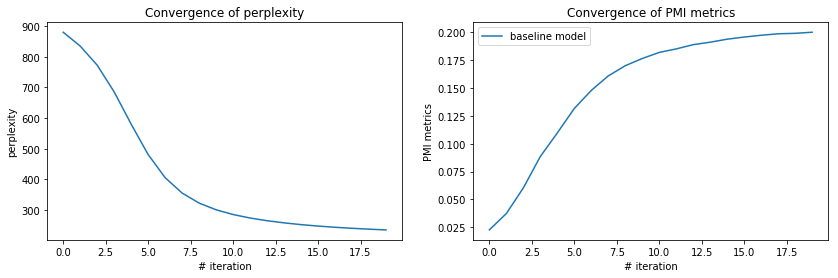

In [19]:
plot_score([train_result_baseline], ['baseline model'])

In [16]:
pickle.dump(train_result_baseline, open('baseline.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
train_result_baseline.get_top_words_in_topics(top_words_count=10)

array([['на', 'команда', 'клуб', 'сезон', 'за', 'матч', 'денис', 'цитата',
        'сборная', 'англия'],
       ['есть', 'президент', 'версия', 'правительство', 'ссылка', 'по',
        'корабль', 'первый', 'представитель', 'можно'],
       ['новый', 'за', 'на', 'свой', 'нет', 'телефон', 'россиянин',
        'финансовый', 'предлагаю', 'мобильный'],
       ['москва', 'слово', 'из', 'результат', 'на', 'год', 'один',
        'последний', 'столичный', 'письмо'],
       ['статья', 'задача', 'характеристика', 'теория', 'объект',
        'участок', 'модель', '19', 'право', 'особенность'],
       ['по', 'есть', 'на', 'решение', 'описание', 'земля', 'сделка',
        'связь', 'этот', 'тот'],
       ['история', '15', '16', '2008', '30', 'для', 'анна', 'россия',
        'общий', 'здание'],
       ['смотрю', 'министр', 'сказал', 'также', 'америка', 'страна',
        'вопрос', 'область', 'сергей', 'лента'],
       ['на', 'есть', 'украина', '12', 'продажа', 'или', 'также', 'луна',
        'государств

X_topics shape = (2789, 50)
X_topics shape = (2789, 50) after theshholding
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2789 samples in 0.010s...
[t-SNE] Computed neighbors for 2789 samples in 0.515s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2789
[t-SNE] Computed conditional probabilities for sample 2000 / 2789
[t-SNE] Computed conditional probabilities for sample 2789 / 2789
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.625793
[t-SNE] Error after 1000 iterations: 1.089450


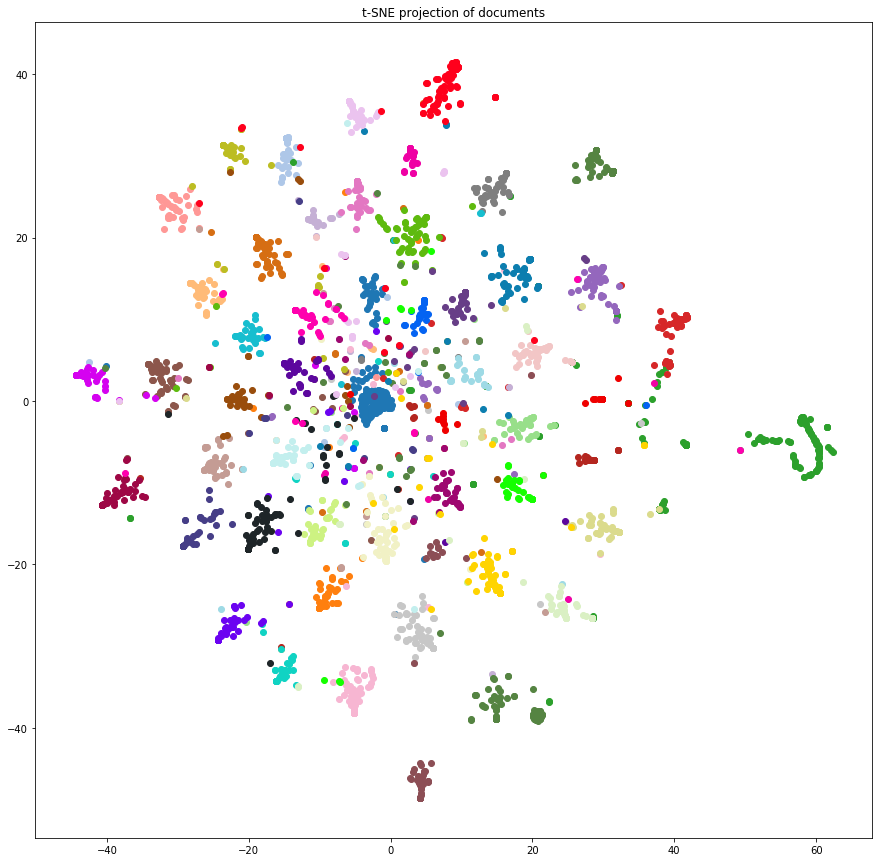

In [21]:
plot_topics(train_result_baseline)

In [22]:
import pyLDAvis

In [23]:
data = pyLDAvis.prepare(topic_term_dists=train_result_baseline.word_in_topic_probs.T, 
                        doc_topic_dists=train_result_baseline.topic_in_doc_probs.T, 
                        doc_lengths=np.array(word_in_doc_freqs_train.sum(axis=0)).ravel(), 
                        vocab=get_words_list(vocabulary), 
                        term_frequency=np.array(word_in_doc_freqs_train.sum(axis=1)).ravel())
pyLDAvis.display(data)

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


### Adding regularizer

In [24]:
regularizers = [CovarianceTopicsRegularizer(tau=1.0, num_topics=50, num_words=words_count, num_docs=docs_count),  
                EliminationOfInsignificantTopics(tau=1.0, num_topics=50, 
                                                num_words=words_count, num_docs=docs_count, 
                                                word_in_doc_freqs=word_in_doc_freqs_train)]

regularizer_weights = [100., 10.]

In [25]:
np.random.seed(42)
train_result_regs_2 = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

iter#1: loglike=-246981.36146940378 pmi_metric=0.021095455872479338
iter#2: loglike=-244980.73837785766 pmi_metric=0.03685488136091555
iter#3: loglike=-242139.249465637 pmi_metric=0.05729605858127459
iter#4: loglike=-237661.17952157249 pmi_metric=0.0866502373689313
iter#5: loglike=-231446.05067468766 pmi_metric=0.11322924230909355
iter#6: loglike=-224519.19386219778 pmi_metric=0.13533745009567977
iter#7: loglike=-218321.56054202013 pmi_metric=0.1548641477077239
iter#8: loglike=-213540.8101905303 pmi_metric=0.1685661218907816
iter#9: loglike=-210070.82085230103 pmi_metric=0.17949972424760272
iter#10: loglike=-207539.01554660045 pmi_metric=0.18551899419608897
iter#11: loglike=-205637.7340587843 pmi_metric=0.19128673084025785
iter#12: loglike=-204170.92673118814 pmi_metric=0.19548576181863803
iter#13: loglike=-203003.56906313842 pmi_metric=0.198301835534713
iter#14: loglike=-202051.3783198376 pmi_metric=0.19979857446974608
iter#15: loglike=-201259.24327145083 pmi_metric=0.2018870652094368

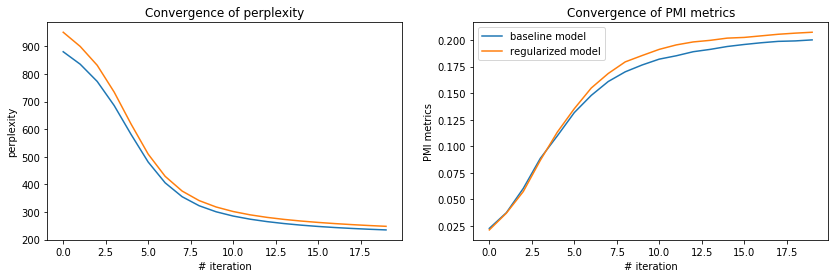

In [26]:
plot_score([train_result_baseline, train_result_regs_2], ['baseline model', 'regularized model'])

In [27]:
pickle.dump(train_result_regs_2, open('regs.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
train_result_regs_2.get_top_words_in_topics(top_words_count=10)

array([['не', 'могу', 'без', 'кто', 'то', 'быть', 'даже', 'наш', 'реклама',
        'на'],
       ['страна', 'борьба', 'женщина', 'власть', 'среди', 'возможность',
        'журналист', 'греция', 'пункт', 'территория'],
       ['он', 'говорю', 'вы', 'не', 'мы', 'она', 'человек', 'за', 'сказал',
        'знаю'],
       ['режиссёр', 'сша', 'михаил', 'по', 'конкурс', 'на', 'сын', 'голос',
        'так', 'первый'],
       ['есть', 'который', 'храм', 'девушка', 'она', 'год', 'он', 'ноябрь',
        'христос', 'фильм'],
       ['служба', 'также', 'ссылка', 'рф', 'орган', 'человек', 'число',
        'государственный', 'федеральный', 'по'],
       ['есть', 'по', 'дом', 'этот', 'весь', 'повод', 'спортивный',
        'фотография', 'единый', 'время'],
       ['мы', 'не', 'наш', 'остаюсь', 'на', 'год', 'такой', 'этот', 'она',
        'что'],
       ['россия', 'являюсь', 'год', 'есть', 'за', 'петербург', 'ура',
        'над', 'москва', 'подготовка'],
       ['15', 'на', 'представитель', 'доллар', 'т

X_topics shape = (2789, 50)
X_topics shape = (2789, 50) after theshholding
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2789 samples in 0.004s...
[t-SNE] Computed neighbors for 2789 samples in 0.555s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2789
[t-SNE] Computed conditional probabilities for sample 2000 / 2789
[t-SNE] Computed conditional probabilities for sample 2789 / 2789
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.187622
[t-SNE] Error after 1000 iterations: 1.076621


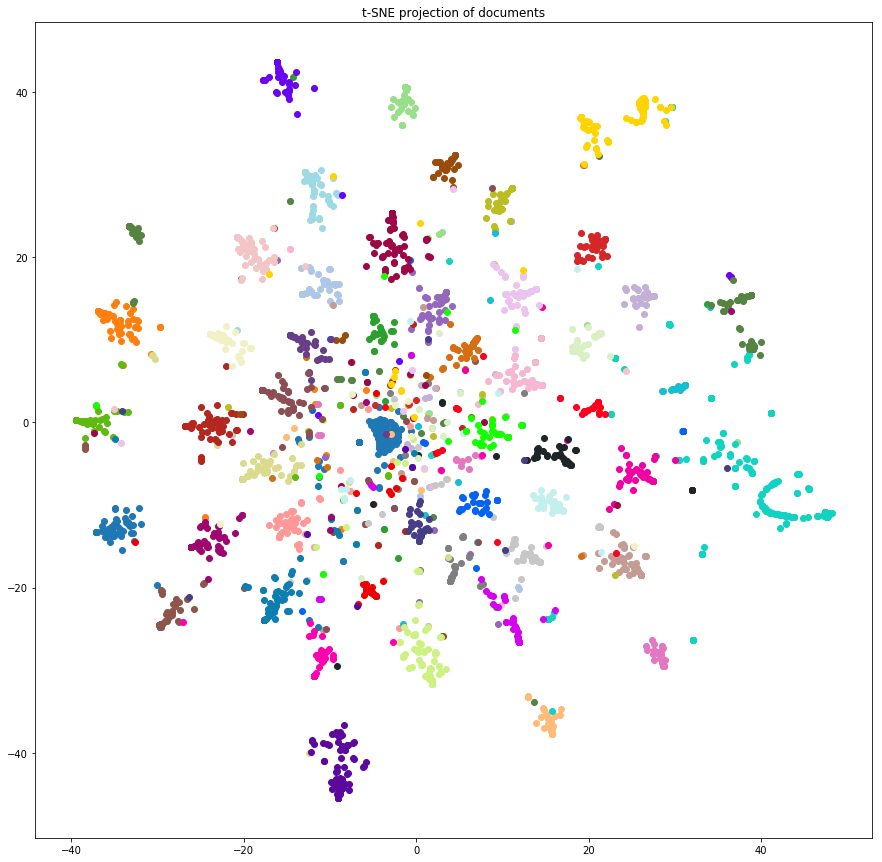

In [29]:
plot_topics(train_result_regs_2)

### Sparsing regularizer

In [30]:
topics_count = 50

In [31]:
regularizers = [SparsingRegularizer(beta_0=0.5, alpha_0=0.5, 
                                    beta=np.array([1e-4]*words_count), 
                                    alpha=np.array([1e-4]*topics_count),
                                    num_topics=topics_count, 
                                    num_words=words_count, 
                                    num_docs=docs_count)]

regularizer_weights = [10.]

In [32]:
np.random.seed(42)
train_result_sparse = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

iter#1: loglike=-243493.8278997904 pmi_metric=0.021339717187286902
iter#2: loglike=-241552.67471891065 pmi_metric=0.03518083222009913
iter#3: loglike=-238662.98747629958 pmi_metric=0.05624920435511932
iter#4: loglike=-234156.43758640997 pmi_metric=0.08308221806719586
iter#5: loglike=-227894.38866367962 pmi_metric=0.11078806736604552
iter#6: loglike=-220859.60238634297 pmi_metric=0.13219278345365854
iter#7: loglike=-214464.72390993364 pmi_metric=0.1512871454269931
iter#8: loglike=-209441.50419792513 pmi_metric=0.1655899735741585
iter#9: loglike=-205746.6168096459 pmi_metric=0.17643094553480826
iter#10: loglike=-203037.73966984442 pmi_metric=0.1831571252271331
iter#11: loglike=-201010.29240737675 pmi_metric=0.18775033798139967
iter#12: loglike=-199458.1685276334 pmi_metric=0.1922471703814777
iter#13: loglike=-198237.298234105 pmi_metric=0.19559799124561977
iter#14: loglike=-197256.71694785557 pmi_metric=0.19682014921272437
iter#15: loglike=-196454.81808295357 pmi_metric=0.199123528764494

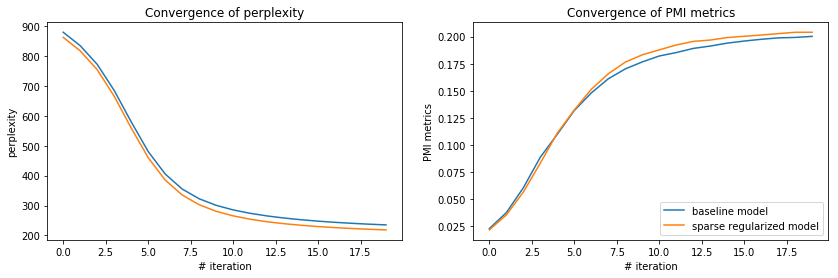

In [33]:
plot_score([train_result_baseline, train_result_sparse], ['baseline model', 'sparse regularized model'])

In [34]:
train_result_sparse.get_top_words_in_topics(top_words_count=10)

array([['не', 'могу', 'без', 'кто', 'то', 'быть', 'на', 'даже', 'реклама',
        'наш'],
       ['страна', 'борьба', 'женщина', 'среди', 'власть', 'возможность',
        'греция', 'журналист', 'пункт', 'территория'],
       ['говорю', 'он', 'не', 'вы', 'мы', 'она', 'сказал', 'за', 'человек',
        'знаю'],
       ['режиссёр', 'на', 'сша', 'михаил', 'по', 'конкурс', 'сын', 'голос',
        'так', 'первый'],
       ['есть', 'который', 'храм', 'девушка', 'она', 'год', 'он', 'ноябрь',
        'христос', 'фильм'],
       ['служба', 'также', 'ссылка', 'рф', 'человек', 'орган', 'число',
        'государственный', 'по', 'федеральный'],
       ['есть', 'по', 'дом', 'этот', 'весь', 'повод', 'спортивный',
        'фотография', 'единый', 'время'],
       ['мы', 'не', 'на', 'наш', 'остаюсь', 'год', 'такой', 'этот', 'она',
        'который'],
       ['россия', 'являюсь', 'есть', 'год', 'за', 'петербург', 'ура',
        'над', 'москва', 'подготовка'],
       ['на', '15', 'представитель', 'доллар'

X_topics shape = (2789, 50)
X_topics shape = (2789, 50) after theshholding
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2789 samples in 0.008s...
[t-SNE] Computed neighbors for 2789 samples in 0.608s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2789
[t-SNE] Computed conditional probabilities for sample 2000 / 2789
[t-SNE] Computed conditional probabilities for sample 2789 / 2789
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.150742
[t-SNE] Error after 1000 iterations: 1.061669


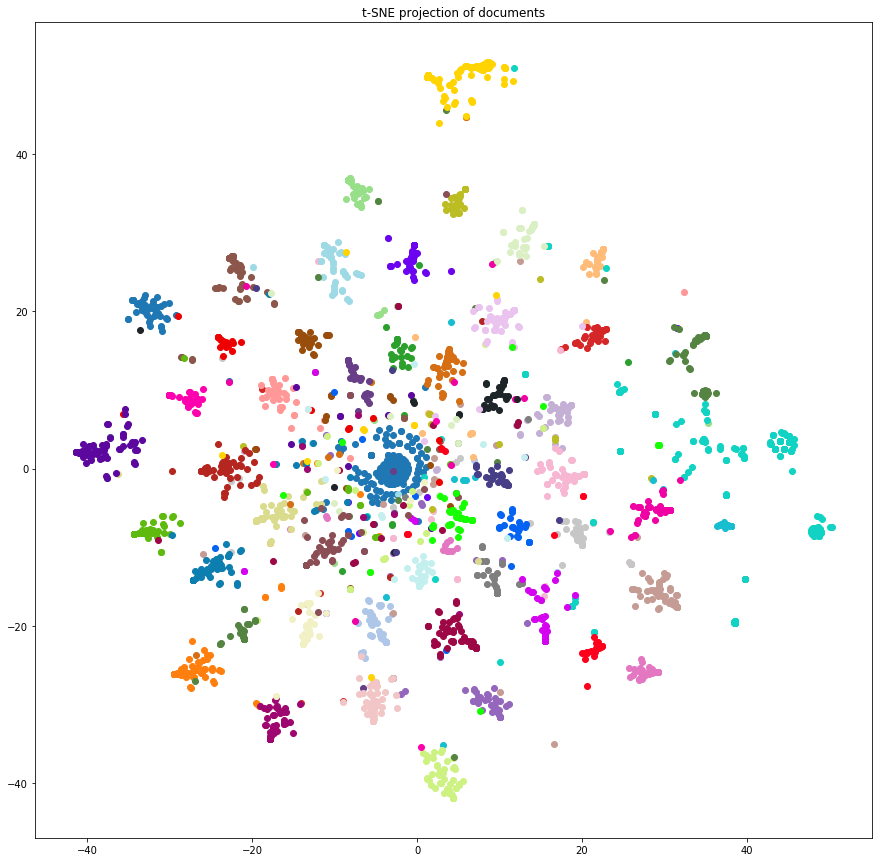

In [35]:
plot_topics(train_result_sparse)

### Classification regularization

In [49]:
regularizers = [ClassificationRegularizer(tau=1.0, num_topics=50, num_docs=docs_count, 
                                          docs_classes=topic, num_words=words_count, 
                                          docs_freq=np.array(word_in_doc_freqs_train.sum(axis=0)))]

regularizer_weights = [1.]

In [ ]:
train_result_class = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

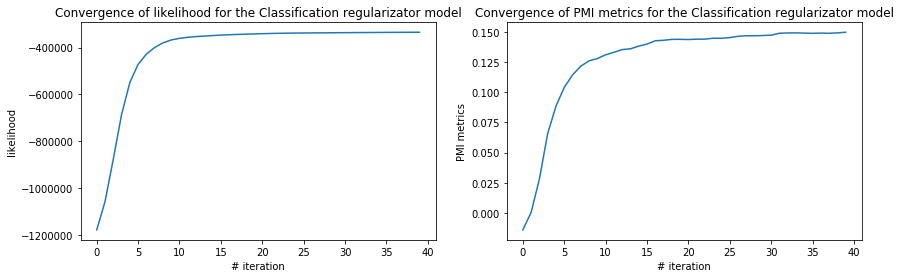

Resulting perplexity = 10876.045568464458
Resulting PMI = 0.14975980369156597


In [32]:
plot_score(train_result_class, 'Classification regularizator model')